# Neural network from scratch.

Based on YSDA Deep Learning course materials.

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

We will implement most common layers using `numpy` for matrix operations. In file `modules.py` are presented the abstract classes for layer, criterion and sequential model class.

The architecture, naming and API are inspired py PyTorch implementation, which will be used in this course further. 

Please, __do not__ change the classes/functions signatures.

In [2]:
# ! wget https://raw.githubusercontent.com/blnglishPlease/ML-and-DL/main/materials/week07_intro_to_DL/modules.py

# from modules import Module, Sequential, Criterion

## Some comments
Original `numpy` operation are more preferable than overloaded ones (`+`, `*`, `-`, etc. vs `np.add`, `np.multiply`, `np.substract`). They show more expectable memory usage and seem unified with tensor frameworks.

*Example:*

```
a = np.zeros_like(arr1)

a = arr1 + arr2 #  bad, we reallocate memory for the result of + operation

a = np.zeros_like(arr1)

np.add(arr1, arr2, out=a) #  good, we use same allocated memory, no need to call gc
```

Before we begin: a [great playground](https://playground.tensorflow.org) to look at.

Try to implement main layers in numpy. Today we stop only on most common ones.

Good read on [Vector, Matrix and Tensor derivatives](http://cs231n.stanford.edu/vecDerivs.pdf)

## Module

In [3]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box) 
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`: 
        
        output = module.forward(input)
    
    The module should be able to perform a backward pass: to differentiate the `forward` function. 
    More, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule. 
    
        gradInput = module.backward(input, gradOutput)
    """
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True
    
    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        return self.updateOutput(input)

    def backward(self,input, gradOutput):
        """
        Performs a backpropagation step through the module, with respect to the given input.
        
        This includes 
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput
    

    def updateOutput(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which is stored in the `output` field.
        
        Make sure to both store the data in `output` field and return it. 
        """
        
        # The easiest case:
            
        # self.output = input 
        # return self.output
        
        pass

    def updateGradInput(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own input. 
        This is returned in `gradInput`. Also, the `gradInput` state variable is updated accordingly.
        
        The shape of `gradInput` is always the same as the shape of `input`.
        
        Make sure to both store the gradients in `gradInput` field and return it.
        """
        
        # The easiest case:
        
        # self.gradInput = gradOutput 
        # return self.gradInput
        
        pass   
    
    def accGradParameters(self, input, gradOutput):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass
    
    def zeroGradParameters(self): 
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass
        
    def getParameters(self):
        """
        Returns a list with its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
        
    def getGradParameters(self):
        """
        Returns a list with gradients with respect to its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
    
    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True
    
    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False
    
    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want 
        to have readable description. 
        """
        return "Module"

## Sequential container

In [4]:
class Sequential(Module):
    """
         This class implements a container, which processes `input` data sequentially. 
         
         `input` is processed by each module (layer) in self.modules consecutively.
         The resulting array is called `output`. 
    """
    
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
   
    def add(self, module):
        """
        Adds a module to the container.
        """
        self.modules.append(module)

    def updateOutput(self, input):
        """
        Basic workflow of FORWARD PASS:
        
            y_0    = module[0].forward(input)
            y_1    = module[1].forward(y_0)
            ...
            output = module[n-1].forward(y_{n-2})   
            
            
        Just write a little loop. 
        """

        # Your code goes here. #
        for elem in self.modules:
            input = elem.forward(input)
        self.output = input 
        return self.output

    def backward(self, input, gradOutput):
        """
        Workflow of BACKWARD PASS:
            
            g_{n-1} = module[n-1].backward(y_{n-2}, gradOutput)
            g_{n-2} = module[n-2].backward(y_{n-3}, g_{n-1})
            ...
            g_1 = module[1].backward(y_0, g_2)   
            gradInput = module[0].backward(input, g_1)   
             
             
        !!!
                
        To ech module you need to provide the input, module saw while forward pass, 
        it is used while computing gradients. 
        Make sure that the input for `i-th` layer the output of `module[i]` (just the same input as in forward pass) 
        and NOT `input` to this Sequential module. 
        
        !!!
        
        """
        # Your code goes here. #
        grad = gradOutput
        for i in range(len(self.modules) - 1, 0, -1):
            grad = self.modules[i].backward(self.modules[i-1].output, grad)
        self.gradInput = self.modules[0].backward(input, grad)
        return self.gradInput
      

    def zeroGradParameters(self): 
        for module in self.modules:
            module.zeroGradParameters()
    
    def getParameters(self):
        """
        Should gather all parameters in a list.
        """
        return [x.getParameters() for x in self.modules]
    
    def getGradParameters(self):
        """
        Should gather all gradients w.r.t parameters in a list.
        """
        return [x.getGradParameters() for x in self.modules]
    
    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string
    
    def __getitem__(self,x):
        return self.modules.__getitem__(x)
    
    def train(self):
        """
        Propagates training parameter through all modules
        """
        self.training = True
        for module in self.modules:
            module.train()
    
    def evaluate(self):
        """
        Propagates training parameter through all modules
        """
        self.training = False
        for module in self.modules:
            module.evaluate()



---



## Layers

### Linear transform layer

Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [5]:
class Linear(Module):
    """
    A module which applies a linear transformation 
    A common name is fully-connected layer, InnerProductLayer in caffe. 
    
    The module should work with 2D input of shape (n_samples, n_feature).
    """
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
       
        # This is a nice initialization
        stdv = 1./np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size = (n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size = n_out)
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, input):
        # Your code goes here. ################################################
        self.output = input@self.W.T + self.b
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradInput = gradOutput@self.W
        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        # Your code goes here. ################################################
        self.gradW = np.sum(input[:, None, :] * gradOutput[:, :, None], axis=0)
        self.gradb = np.sum(gradOutput, axis=0)
        pass
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return q

### SoftMax

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.


In [6]:
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()
    
    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        
        # Your code goes here. ################################################
        np.exp(self.output, out=self.output)
        np.divide(self.output, self.output.sum(axis=1, keepdims=True), out=self.output)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        size = input.shape[-1]
        gradSoft = -self.output[:, :, None]*self.output[:, None, :]
        gradSoft[:, range(size), range(size)] += np.sqrt(-gradSoft[:, range(size), range(size)])
        self.gradInput = np.squeeze(gradOutput[:, None, :] @ gradSoft)
        return self.gradInput
    
    def __repr__(self):
        return "SoftMax"

### LogSoftMax

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [7]:
class LogSoftMax(Module):
    def __init__(self):
         super(LogSoftMax, self).__init__()
    
    def updateOutput(self, input):
        # start with normalization for numerical stability
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        
        # Your code goes here. ################################################
        np.exp(self.output, out=self.output)
        np.divide(self.output, self.output.sum(axis=1, keepdims=True), out=self.output)
        self.output = np.log(self.output)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. ################################################
        grad = np.zeros((input.shape[0], input.shape[1], input.shape[1]))
        normal = np.subtract(input, input.max(axis=1, keepdims=True) - 1)
        normalSoftMax = 1 / np.sum(np.exp(normal), axis=1)
        for x in range(input.shape[1]):
            for y in range(input.shape[1]):
                grad[:, x, y] = -normalSoftMax * np.exp(normal[:, y])
            grad[:, x, x] += 1
        self.gradInput = np.squeeze(gradOutput[:, None, :] @ grad)
        return self.gradInput
    
    def __repr__(self):
        return "LogSoftMax"

### Batch Normalization

One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance: 
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance. 

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.


In [8]:
class BatchNormalization(Module):
    
    def __init__(self, alpha = 0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None 
        self.moving_variance = None
        self.EPS = 1e-3
        
    def updateOutput(self, input):
        # Your code goes here. #
        # use self.EPS please
        if self.training:
            var = np.var(input, axis=0)
            mean = np.mean(input, axis=0)
            self.output = (input - mean) / np.sqrt(var + self.EPS)
            if self.moving_mean is None:
                self.moving_mean = mean
                self.moving_variance = var
            else:
                self.moving_mean = self.moving_mean * self.alpha + mean * (1 - self.alpha)
                self.moving_variance = self.moving_variance * self.alpha + var * (1 - self.alpha)
        else:
            var = self.moving_variance
            mean = self.moving_mean
            self.output = (input - mean) / np.sqrt(var + self.EPS) 
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. #
        var = np.var(input, axis=0)
        norm = input - np.mean(input, axis=0)                  
        sqvar = np.sqrt(var + self.EPS)
        self.gradInput = (gradOutput - np.mean(gradOutput, axis=0) - \
                          np.mean(gradOutput * norm, axis=0) * norm / (var + self.EPS)) / sqvar
        return self.gradInput
    
    def __repr__(self):
        return "BatchNormalization"

Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

### Channelwise Scaling

In [9]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)
        
        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def updateOutput(self, input):
        self.output = input * self.gamma + self.beta
        return self.output
        
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.gamma
        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        self.gradBeta = np.sum(gradOutput, axis=0)
        self.gradGamma = np.sum(gradOutput*input, axis=0)
    
    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)
        
    def getParameters(self):
        return [self.gamma, self.beta]
    
    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]
    
    def __repr__(self):
        return "ChannelwiseScaling"

### Dropout

Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [10]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        
        self.p = p
        self.mask = None
        
    def updateOutput(self, input):
        # Your code goes here. #
        self.output = input
        if self.training:
            self.mask = np.random.binomial(1, 1. - self.p, input.shape)
            self.output = input * self.mask / (1. - self.p)
        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. #
        self.gradInput = gradOutput * self.mask / (1 - self.p)
        return self.gradInput
        
    def __repr__(self):
        return "Dropout"



---



## Activation functions

### ReLU

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [11]:
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def updateOutput(self, _input):
        self.output = np.maximum(_input, 0)
        return self.output
    
    def updateGradInput(self, _input, gradOutput):
        self.gradInput = np.multiply(gradOutput , _input > 0)
        return self.gradInput
    
    def __repr__(self):
        return "ReLU"

### LeakyReLU

Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope. 


In [12]:
class LeakyReLU(Module):
    def __init__(self, slope = 0.03):
        super(LeakyReLU, self).__init__()
            
        self.slope = slope
        
    def updateOutput(self, input):
        # Your code goes here. #
        self.output = np.maximum(input, 0) + np.minimum(input, 0)*self.slope
        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. #
        self.gradInput = np.multiply(gradOutput, input > 0) + np.multiply(gradOutput, input < 0) * self.slope
        return self.gradInput
    
    def __repr__(self):
        return "LeakyReLU"

### ELU

Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.


In [13]:
class ELU(Module):
    def __init__(self, alpha = 1.0):
        super(ELU, self).__init__()
        
        self.alpha = alpha
        
    def updateOutput(self, input):
        # Your code goes here. #
        self.output = np.minimum(0, (np.exp(input) - 1) * self.alpha) + np.maximum(0, input) 
        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. #
        self.gradInput = self.alpha * np.exp(input) * np.multiply(gradOutput, input < 0) +\
                         np.multiply(gradOutput, input > 0)
        return self.gradInput
    
    def __repr__(self):
        return "ELU"

### SoftPlus



Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [14]:
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()
    
    def updateOutput(self, input):
        # Your code goes here. #
        self.output = np.log(np.exp(input) + 1)
        return  self.output
    
    def updateGradInput(self, input, gradOutput):
        # Your code goes here. #
        self.gradInput = np.multiply(gradOutput, 1 / (np.exp(-input) + 1))
        return self.gradInput
    
    def __repr__(self):
        return "SoftPlus"



---



## Criterions

Criterions are used to score the models answers.


In [15]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        
    def forward(self, input, target):
        """
            Given an input and a target, compute the loss function 
            associated to the criterion and return the result.
            
            For consistency this function should not be overrided,
            all the code goes in `updateOutput`.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
            Given an input and a target, compute the gradients of the loss function
            associated to the criterion and return the result. 

            For consistency this function should not be overrided,
            all the code goes in `updateGradInput`.
        """
        return self.updateGradInput(input, target)
    
    def updateOutput(self, input, target):
        """
        Function to override.
        """
        return self.output

    def updateGradInput(self, input, target):
        """
        Function to override.
        """
        return self.gradInput   

    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want 
        to have readable description. 
        """
        return "Criterion"

### MSE Criterion

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [16]:
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()
        
    def updateOutput(self, input, target):   
        self.output = np.sum(np.power(input - target, 2)) / input.shape[0]
        return self.output 
 
    def updateGradInput(self, input, target):
        self.gradInput  = (input - target) * 2 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"

### Negative LogLikelihood criterion (numerically unstable)

Your task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula, 
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

In [17]:
class ClassNLLCriterionUnstable(Criterion):
    EPS = 1e-15
    def __init__(self):
        a = super(ClassNLLCriterionUnstable, self)
        super(ClassNLLCriterionUnstable, self).__init__()
        
    def updateOutput(self, input, target): 
        
        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
        
        # Your code goes here. ################################################
        self.output = -np.sum(target * np.log(input_clamp)) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        
        # Use this trick to avoid numerical errors
        input_clamp = np.clip(input, self.EPS, 1 - self.EPS)
                
        # Your code goes here. ################################################
        self.gradInput = -target / input.shape[0] / input_clamp
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterionUnstable"

### Negative LogLikelihood criterion (numerically stable)

- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().


In [18]:
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()
        
    def updateOutput(self, input, target): 
        # Your code goes here. ################################################
        self.output = -np.sum(target*input) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        # Your code goes here. ################################################
        self.gradInput = -target / input.shape[0]
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterion"



---



## Optimizers

### Simple SGD

In [19]:
def simple_sgd(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})
    
    var_index = 0 
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            
            current_var -= config['learning_rate'] * current_grad
            var_index += 1     

### SGD optimizer with momentum


- `variables` - list of lists of variables (one list per layer)
- `gradients` - list of lists of current gradients (same structure as for `variables`, one array for each var)
- `config` - dict with optimization parameters (`learning_rate` and `momentum`)
- `state` - dict with optimizator state (used to save accumulated gradients)

In [20]:
def sgd_momentum(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('accumulated_grads', {})
    
    var_index = 0 
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            
            old_grad = state['accumulated_grads'].setdefault(var_index, np.zeros_like(current_grad))
            
            np.add(config['momentum'] * old_grad, config['learning_rate'] * current_grad, out=old_grad)
            
            current_var -= old_grad
            var_index += 1

### [Adam](https://arxiv.org/pdf/1412.6980.pdf) optimizer


- `variables` - list of lists of variables (one list per layer)
- `gradients` - list of lists of current gradients (same structure as for `variables`, one array for each var)
- `config` - dict with optimization parameters (`learning_rate`, `beta1`, `beta2`, `epsilon`)
- `state` - dict with optimizator state (used to save 1st and 2nd moment for vars)

Formulas for optimizer:

Current step learning rate: $$\text{lr}_t = \text{learning_rate} * \frac{\sqrt{1-\beta_2^t}} {1-\beta_1^t}$$
First moment of var: $$\mu_t = \beta_1 * \mu_{t-1} + (1 - \beta_1)*g$$ 
Second moment of var: $$v_t = \beta_2 * v_{t-1} + (1 - \beta_2)*g*g$$
New values of var: $$\text{variable} = \text{variable} - \text{lr}_t * \frac{m_t}{\sqrt{v_t} + \epsilon}$$

In [21]:
def adam_optimizer(variables, gradients, config, state):  
    # 'variables' and 'gradients' have complex structure, accumulated_grads will be stored in a simpler one
    state.setdefault('m', {})  # first moment vars
    state.setdefault('v', {})  # second moment vars
    state.setdefault('t', 0)   # timestamp
    state['t'] += 1
    for k in ['learning_rate', 'beta1', 'beta2', 'epsilon']:
        assert k in config, config.keys()
    
    var_index = 0 
    lr_t = config['learning_rate'] * np.sqrt(1 - config['beta2']**state['t']) / (1 - config['beta1']**state['t'])
    for current_layer_vars, current_layer_grads in zip(variables, gradients): 
        for current_var, current_grad in zip(current_layer_vars, current_layer_grads):
            var_first_moment = state['m'].setdefault(var_index, np.zeros_like(current_grad))
            var_second_moment = state['v'].setdefault(var_index, np.zeros_like(current_grad))
            
            # <YOUR CODE> #
            # update `current_var_first_moment`, `var_second_moment` and `current_var` values
            np.add(var_first_moment * config['beta1'], (1 - config['beta1']) * current_grad, out=var_first_moment)
            np.add(var_second_moment * config['beta2'], (1 - config['beta2']) * current_grad**2, out=var_second_moment)
            current_var -= var_first_moment * lr_t / (np.sqrt(var_second_moment) + config['epsilon'])
            
            # small checks that you've updated the state; use np.add for rewriting np.arrays values
            assert var_first_moment is state['m'].get(var_index)
            assert var_second_moment is state['v'].get(var_index)
            var_index += 1



---



## Convolutional layers

### Conv2d **(TODO)**

- input:   **`batch_size x in_channels x h x w`**
- output: **`batch_size x out_channels x h x w`**

You should implement something like pytorch `Conv2d` layer with `stride=1` and zero-padding outside of image using `scipy.signal.correlate` function.

Practical notes:
- While the layer name is "convolution", the most of neural network frameworks (including tensorflow and pytorch) implement operation that is called [correlation](https://en.wikipedia.org/wiki/Cross-correlation#Cross-correlation_of_deterministic_signals) in signal processing theory. So **don't use** `scipy.signal.convolve` since it implements [convolution](https://en.wikipedia.org/wiki/Convolution#Discrete_convolution) in terms of signal processing.
- It may be convenient to use `skimage.util.pad` for zero-padding.
- It's rather ok to implement convolution over 4d array using 2 nested loops: one over batch size dimension and another one over output filters dimension
- Having troubles with understanding how to implement the layer? 
 - Check the last year video of lecture 3 (starting from ~1:14:20)
 - May the google be with you

In [22]:
import scipy as sp
import scipy.signal
import skimage

class Conv2d(Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(Conv2d, self).__init__()
        assert kernel_size % 2 == 1, kernel_size
       
        stdv = 1./np.sqrt(in_channels)
        self.W = np.random.uniform(-stdv, stdv, size = (out_channels, in_channels, kernel_size, kernel_size))
        self.b = np.random.uniform(-stdv, stdv, size=(out_channels,))
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, input):
        pad_size = self.kernel_size // 2
        # YOUR CODE ##############################
        # 1. zero-pad the input array
        # 2. compute convolution using scipy.signal.correlate(... , mode='valid')
        # 3. add bias value
        
        # self.output = ...
        
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        pad_size = self.kernel_size // 2
        # YOUR CODE ##############################
        # 1. zero-pad the gradOutput
        # 2. compute 'self.gradInput' value using scipy.signal.correlate(... , mode='valid')
        
        # self.gradInput = ...
        
        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        pad_size = self.kernel_size // 2
        # YOUR CODE #############
        # 1. zero-pad the input
        # 2. compute 'self.gradW' using scipy.signal.correlate(... , mode='valid')
        # 3. compute 'self.gradb' - formulas like in Linear of ChannelwiseScaling layers
        
        # self.gradW = ...
        # self.gradb = ...
        pass
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Conv2d %d -> %d' %(s[1],s[0])
        return q

### MaxPool2d **(TODO)**


- input:   **`batch_size x n_input_channels x h x w`**
- output: **`batch_size x n_output_channels x h // kern_size x w // kern_size`**

You are to implement simplified version of pytorch `MaxPool2d` layer with stride = kernel_size. Please note, that it's not a common case that stride = kernel_size: in AlexNet and ResNet kernel_size for max-pooling was set to 3, while stride was set to 2. We introduce this restriction to make implementation simplier.

Practical notes:
- During forward pass what you need to do is just to reshape the input tensor to `[n, c, h / kern_size, kern_size, w / kern_size, kern_size]`, swap two axes and take maximums over the last two dimensions. Reshape + axes swap is sometimes called space-to-batch transform.
- During backward pass you need to place the gradients in positions of maximal values taken during the forward pass
- In real frameworks the indices of maximums are stored in memory during the forward pass. It is cheaper than to keep the layer input in memory and recompute the maximums.


In [23]:
class MaxPool2d(Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.gradInput = None
                    
    def updateOutput(self, input):
        input_h, input_w = input.shape[-2:]
        # your may remove these asserts and implement MaxPool2d with padding
        assert input_h % self.kernel_size == 0  
        assert input_w % self.kernel_size == 0
        
        # YOUR CODE #############################
        # self.output = ...
        # self.max_indices = ...
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        # YOUR CODE #############################
        # self.gradInput = ...
        return self.gradInput
    
    def __repr__(self):
        q = 'MaxPool2d, kern %d, stride %d' %(self.kernel_size, self.kernel_size)
        return q

### Flatten layer

Just reshapes inputs and gradients. It's usually used as proxy layer between Conv2d and Linear.


In [24]:
class Flatten(Module):
    def __init__(self):
         super(Flatten, self).__init__()
    
    def updateOutput(self, input):
        self.output = input.reshape(len(input), -1)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput.reshape(input.shape)
        return self.gradInput
    
    def __repr__(self):
        return "Flatten"



---



# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

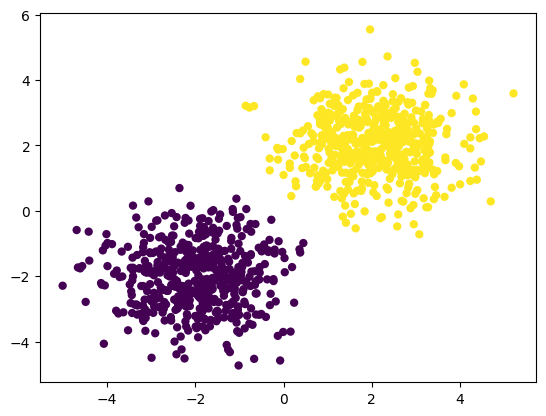

In [25]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [30]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [27]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [28]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

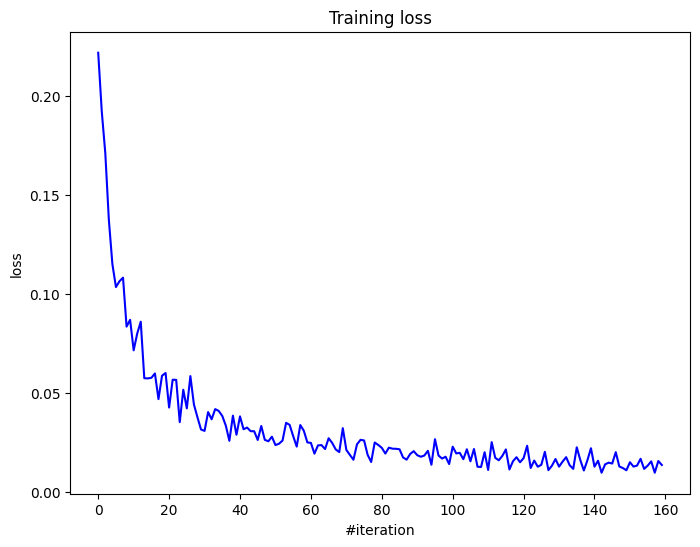

100%|██████████| 20/20 [00:08<00:00,  2.42it/s]

Current loss: 0.013512


In [31]:
loss_history = []

for i in tqdm(range(n_epoch)):
    for x_batch, y_batch in tqdm(get_batches((X, Y), batch_size)):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        simple_sgd(net.getParameters(), 
                   net.getGradParameters(), 
                   optimizer_config,
                   optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [32]:
! wget https://raw.githubusercontent.com/blnglishPlease/ML-and-DL/main/materials/week07_intro_to_DL/mnist.py

import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

--2023-05-13 02:32:51--  https://raw.githubusercontent.com/blnglishPlease/ML-and-DL/main/materials/week07_intro_to_DL/mnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2693 (2.6K) [text/plain]
Saving to: ‘mnist.py.3’

mnist.py.3          100%[===================>]   2.63K  --.-KB/s    in 0s      

2023-05-13 02:32:51 (36.2 MB/s) - ‘mnist.py.3’ saved [2693/2693]



One-hot encode the labels first.

In [33]:
from sklearn.preprocessing import OneHotEncoder

X_train = np.expand_dims(X_train, 1)
X_val = np.expand_dims(X_val, 1)
X_test = np.expand_dims(X_test, 1)

encoder = OneHotEncoder(categories='auto', sparse=False)

y_train = encoder.fit_transform(y_train.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [34]:
X_train, X_val, X_test = list(map(lambda x: x.reshape((x.shape[0], -1)), [X_train, X_val, X_test]))

In [35]:
X_train.shape

(50000, 784)

In [36]:
net = Sequential()
net.add(Linear(784, 128))
net.add(ReLU())
net.add(Linear(128, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear 784 -> 128
ReLU
Linear 128 -> 10
LogSoftMax



In [37]:
# Optimizer params
optimizer_config = {'learning_rate' : 3e-3, 'beta1': 0.99, 'beta2': 0.99, 'epsilon': 1e-5}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

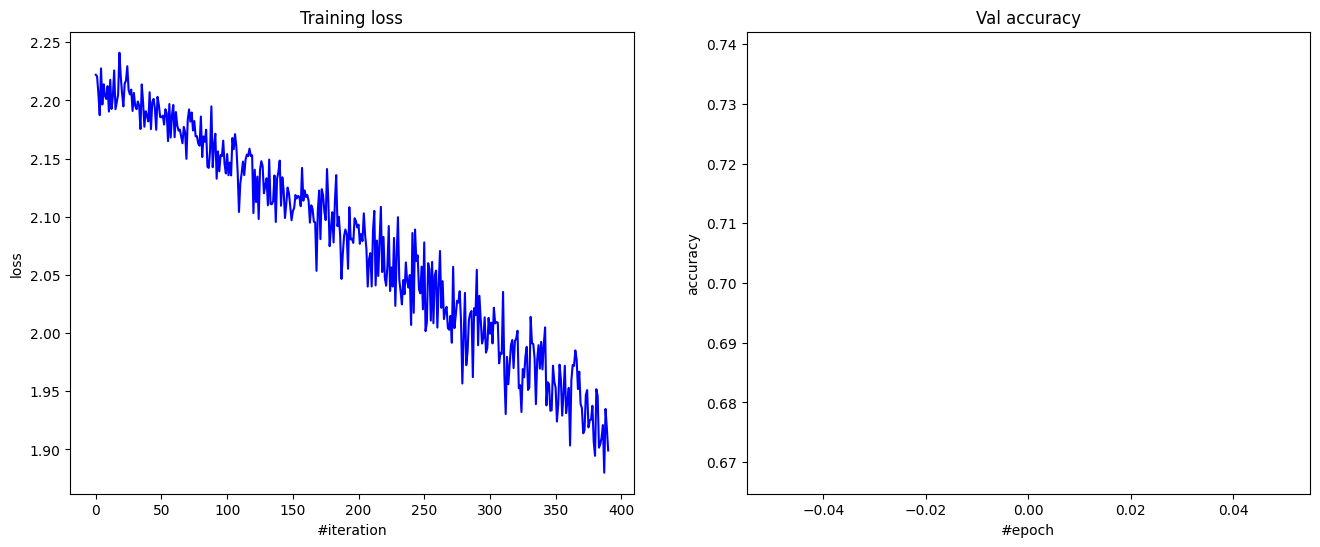

  5%|▌         | 1/20 [00:33<10:37, 33.57s/it]

Current loss: 1.899141


In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

loss_history = []
accuracy_history = []

for i in tqdm(range(n_epoch)):
    net.train()
    for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        simple_sgd(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
    
    net.evaluate()
    accuracy_history.append(accuracy_score(net.forward(X_val).argmax(axis=-1), y_val))
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)    
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    
    plt.subplot(1, 2, 2)
    plt.title("Val accuracy")
    plt.xlabel("#epoch")
    plt.ylabel("accuracy")
    plt.plot(accuracy_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)   